In [2]:
import glob
from ase.io import read, write
from ase.formula import Formula
import re
import os.path as osp
from tqdm.auto import tqdm

from ovito.io import import_file
from ovito.modifiers import CoordinationAnalysisModifier, TimeAveragingModifier

import pandas as pd

from pathlib import Path

from matplotlib import pyplot as plt

a = Formula('NaCl')
b = Formula('UCl3')

phases = [str(a), str(b)]
work_dir = f"{str(a)}-{str(b)}"

directories = sorted(glob.glob(osp.join(work_dir, '*/')))

compositons = []
pdfs = []

for directory in tqdm(directories):
    files = sorted(glob.glob(osp.join(directory, 'production.traj')), key=lambda f: list(map(int, re.findall("\d+", f))))

    if len(files) == 0:
        continue
    traj = []
    print(files[-1])
    traj.extend(read(files[-1], index=":"))
    
    formula = traj[-1].symbols.formula
    
    portions = {}
    for phase in phases:
        portions[phase] = formula // phase
        
    total_units = sum(portions.values())

    fractions = {}
    for phase in phases:
        fractions[phase] = portions[phase] / total_units
    
    compositons.append(fractions[phases[-1]])
        
    path = Path(files[-1]).with_suffix('.extxyz')
    write(path, traj)

    pipeline = import_file(path)
    
    print(pipeline.source.num_frames)

    # Insert the RDF calculation modifier into the pipeline:
    pipeline.modifiers.append(CoordinationAnalysisModifier(
        cutoff = 14, 
        number_of_bins = 200,
        partial=True
    ))  

    # Insert the time-averaging modifier into the pipeline, which accumulates
    # the instantaneous DataTable produced by the previous modifier and computes a mean histogram.
    pipeline.modifiers.append(TimeAveragingModifier(operate_on='table:coordination-rdf'))

    # Data export method 1: Convert to NumPy array and write data to a text file:
    rdf_table = pipeline.compute().tables['coordination-rdf[average]']

    rdf_names = rdf_table.y.component_names
    
    pdfs.append({})

    for component, name in enumerate(rdf_names):
        
        pdfs[-1][name] = rdf_table.y[:, component]


  0%|          | 0/11 [00:00<?, ?it/s]

NaCl-UCl3/Cl104Na8U32/production.traj
5000


  9%|▉         | 1/11 [01:00<10:03, 60.39s/it]

NaCl-UCl3/Cl112Na4U36/production.traj
5000


 18%|█▊        | 2/11 [02:01<09:04, 60.55s/it]

NaCl-UCl3/Cl112Na64U16/production.traj
5000


 27%|██▋       | 3/11 [03:06<08:22, 62.83s/it]

NaCl-UCl3/Cl120U40/production.traj
5000


 36%|███▋      | 4/11 [04:16<07:39, 65.65s/it]

NaCl-UCl3/Cl64Na28U12/production.traj
5000


 45%|████▌     | 5/11 [05:15<06:18, 63.14s/it]

NaCl-UCl3/Cl72Na24U16/production.traj
5000


 55%|█████▍    | 6/11 [06:02<04:48, 57.69s/it]

NaCl-UCl3/Cl80Na20U20/production.traj
5000


 64%|██████▎   | 7/11 [07:01<03:53, 58.25s/it]

NaCl-UCl3/Cl80Na80/production.traj
5000


 73%|███████▎  | 8/11 [08:13<03:07, 62.55s/it]

NaCl-UCl3/Cl88Na16U24/production.traj
5000


 82%|████████▏ | 9/11 [09:06<01:59, 59.58s/it]

NaCl-UCl3/Cl96Na12U28/production.traj
5000


 91%|█████████ | 10/11 [10:09<01:00, 60.65s/it]

NaCl-UCl3/Cl96Na72U8/production.traj
5000


100%|██████████| 11/11 [11:18<00:00, 61.70s/it]


'Cl-U'
'U-U'


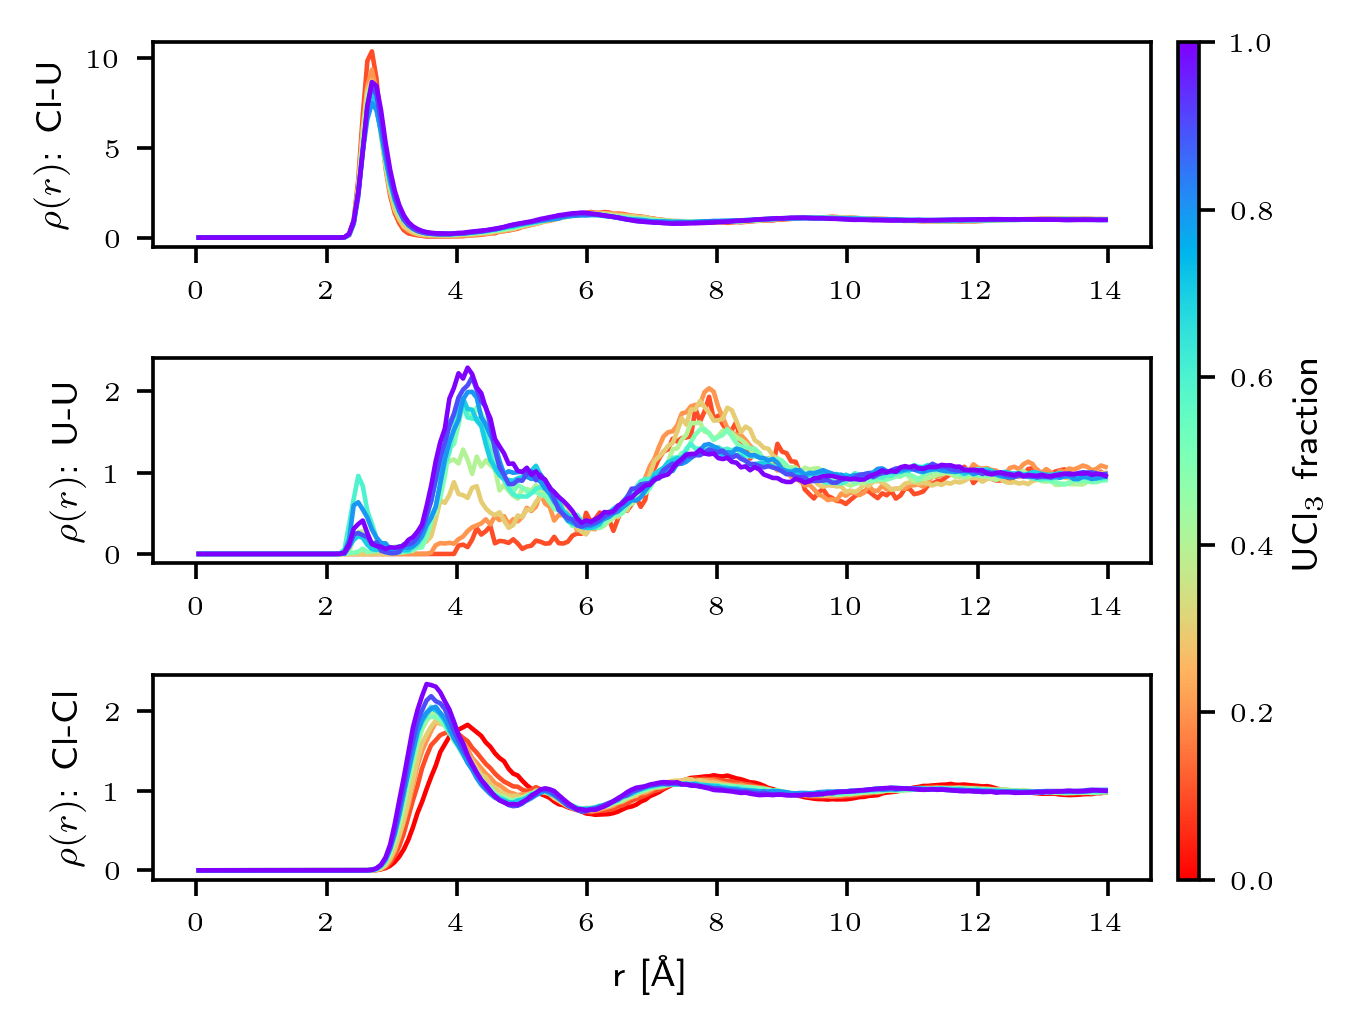

In [3]:
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

cmap_data = [
    (1.0, 0.0, 0.0),  # Red at 1
    # (0.5, 0.0, 0.5),  # Purple at 0.5 
    (0.0, 0.0, 1.0),  # Blue at 0
]
# cmap = LinearSegmentedColormap.from_list('custom_colormap', cmap_data)
cmap = plt.get_cmap('rainbow_r')


compositions = np.array(compositons)
idx = np.argsort(compositions)

with plt.style.context("default"):
    
    SMALL_SIZE = 6
    MEDIUM_SIZE = 8
    LARGE_SIZE = 10

    LINE_WIDTH = 1

    plt.rcParams.update({
        'pgf.texsystem': 'pdflatex',
        'font.family': 'sans-serif',
        'text.usetex': True,
        'pgf.rcfonts': True,
        'figure.constrained_layout.use': True,
        'axes.labelsize': MEDIUM_SIZE,
        'axes.titlesize': MEDIUM_SIZE,
        'legend.frameon': False,
        'legend.fontsize': MEDIUM_SIZE,
        'legend.loc': 'best',
        'lines.linewidth': LINE_WIDTH,
        'xtick.labelsize': SMALL_SIZE,
        'ytick.labelsize': SMALL_SIZE,
    })
    
    fig, axes = plt.subplot_mosaic(
        """
        aC
        bC
        cC
        """,
        layout="constrained",
        # sharex=True,
        figsize=(4, 3),
        gridspec_kw={'width_ratios': [0.98, 0.02]},
        dpi=330
    )
    
    norm = plt.Normalize(0, 1)
    
    
    for i in idx[::1]:
        
        for ax, pair in zip(['a', 'b', 'c'], ['Cl-U', 'U-U', 'Cl-Cl']):
            try:
                p = axes[ax].plot(
                    rdf_table.xy()[:, 0],
                    pdfs[i][pair],
                    color=cmap(norm(compositions[i])),
                    # norm=norm,
                    # label=compositons[i]
                )
            except Exception as e:
                print(e)
                
            axes[ax].set(
                ylabel=f"$\\rho(r)$: {pair}",
            )
            if ax == 'c':
                axes[ax].set(
                    xlabel="r [$\sf\AA$]"
                )
            
            # axes[ax].legend()
    
    # cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])  # [left, bottom, width, height]
    mappable = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    mappable.set_array(compositions)
    cbar = plt.colorbar(mappable, cax=axes['C'], label=f'{b:latex} fraction')
    plt.savefig(
        f"{work_dir}/{a}-{b}-production.pdf"
    )
    plt.show()


In [36]:
from typing import Sequence
from ase import Atoms

def calc_acf(traj: Sequence[Atoms]):
    traj_stress = []
    traj_volumes = []

    for atoms in  traj:

        traj_stress.append(atoms.get_stress())
        traj_volumes.append(atoms.get_volume())

    assert len(traj_stress) == len(traj)

    traj_stress = np.vstack(traj_stress)

    nsteps = len(traj)

    acf = np.zeros((nsteps//2, 3))

    for tau in range(len(acf)):

        acf[tau, :] = np.mean(traj_stress[:(nsteps-tau), 3:] * traj_stress[tau:, 3:])

    acf_mean = acf.mean(axis=1)
    
    return traj_volumes, acf_mean



100%|██████████| 11/11 [00:08<00:00,  1.25it/s]


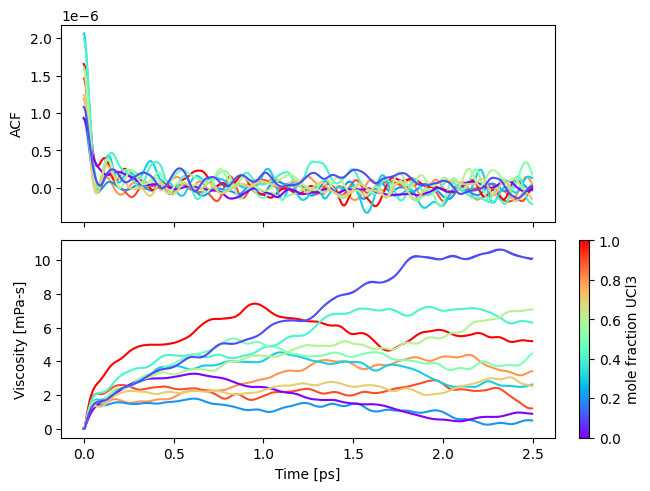

In [44]:
import os.path as osp
from matplotlib import pyplot as plt
from matplotlib.cm import ScalarMappable
from ase.formula import Formula
import math
import glob
from tqdm.auto import tqdm
import re
from pathlib import Path
from ase import units

a = Formula("NaCl")
b = Formula("UCl3")

comps = sorted(glob.glob(f'{a}-{b}/*/'))

mode = 'npt'

dt = 5 * units.fs
temp = 1100  # K

with plt.style.context("default"):
    
    fig, axes = plt.subplot_mosaic(
        """
        a
        b
        """,
        layout="constrained",
        sharex=True
    )
    
    cmap = plt.get_cmap('rainbow')
    
    norm = plt.Normalize(0, 1)
    
    # Create a ScalarMappable for mapping custom values to colors
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])  # set_array needs to be called with an empty array
    

    for comp in tqdm(comps):
        files = sorted(glob.glob(f'{comp}*-{mode}*.traj'), key=lambda x: [float(num) for num in re.findall(r'\d+\.\d+|\d+', x)])

        traj = []

        for file in tqdm(files[-1:]):
            traj.extend(read(file, index=":"))
            
        vol_file = f'{comp}volumes-{mode}'
        acf_file = f'{comp}acf_mean-{mode}'
            
        if osp.exists(vol_file) and osp.exists(acf_file):
            volumes = np.load(vol_file)
            acf_mean = np.load(acf_file)

        else:
            volumes, acf_mean = calc_acf(traj)
        
            np.save(vol_file, volumes)
            np.save(acf_file, acf_mean)
        
        # V = np.mean(traj_volumes)
        ts = np.arange(len(acf_mean)) * dt  / units.fs
        
        formula = Formula(traj[0].get_chemical_formula(mode="reduce"))
        
        x = (formula//b*1.0) / (formula // a + formula//b)

        i = 'a'
        
        axes[i].plot(
            ts / 1e3, acf_mean, label=f'{formula:latex}', 
            # color=x, cmap=cmap, norm=norm,
            color=sm.to_rgba(x)
        )

        i = 'b'

        factor = 1 / (units.kB * temp * units.fs) * (0.001 * units.Pascal * units.s)

        p = axes[i].plot(
            ts / 1e3, 
            [factor * volumes[t] * np.trapz(y=acf_mean[:t], dx=dt) for t in range(len(acf_mean))],
            # color=x, cmap=cmap, norm=norm
            color=sm.to_rgba(x)
        )

    ylo, yhi = axes['a'].get_ylim()
    axes['a'].set(ylabel='ACF', ylim=(ylo, yhi))
    axes['b'].set(xlabel='Time [ps]', ylabel='Viscosity [mPa-s]')
    
    # axes['a'].legend(loc='upper left', bbox_to_anchor=(1, 1))
    
    # cbar_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8])
    cbar = plt.colorbar(sm, ax=axes['b'])
    cbar.set_label(f"mole fraction {b}")
    
    plt.savefig(f"{a}-{b}/viscosity-{mode}.png")
    plt.savefig(f"{a}-{b}/viscosity-{mode}.pdf")
    plt.show()
